# IBM SkillsBuild Hydropower Climate Optimisation Challenge Solution Overview

# Original Setup

* Python version 3.10.0 was used for the notebook interpreter
* Packages used: pandas, numpy, seaborn, scikit-learn, darts, matplotlib, optuna. For version locking the required packages can be found in `requirements.txt` and installed via `$ pip install -r ./requirements.txt`
* Assumed setup is the the `final_submission.ipynb` is at the root level, while uncompressed data is contained in a folder called `./data/`

# Solution Overview

## Overview and Objectives

This notebook presents the final solution for the IBM SkillsBuild Hydropower Climate Optimisation Challenge. The task is to predict future energy load generation (in kWh) in the remote Kalam region of Pakistan using a combination of micro-hydropower plant (MHP) data and local climate data.

### Purpose
The aim of this solution is to enable accurate 31-day-ahead forecasting of daily power usage, which is crucial for optimizing energy distribution, reducing waste, and improving the resilience of off-grid communities reliant on hydropower.

### Objectives
- Efficiently handle and transform large-scale hydropower and climate datasets using DuckDB to ensure scalability and memory efficiency.
- Aggregate raw data into a consistent daily granularity, aligning all time series for effective modeling.
- Engineer relevant features from both power and climate data to enhance predictive capability.
- Develop and evaluate a robust forecasting model using the Darts `LinearRegressionModel`, leveraging lagged features and covariates.
- Document the entire ETL and modeling pipeline for transparency, reproducibility, and deployment readiness.

This solution focuses on simplicity, efficiency, and interpretability while maintaining strong forecasting performance.

## Architecture Diagram

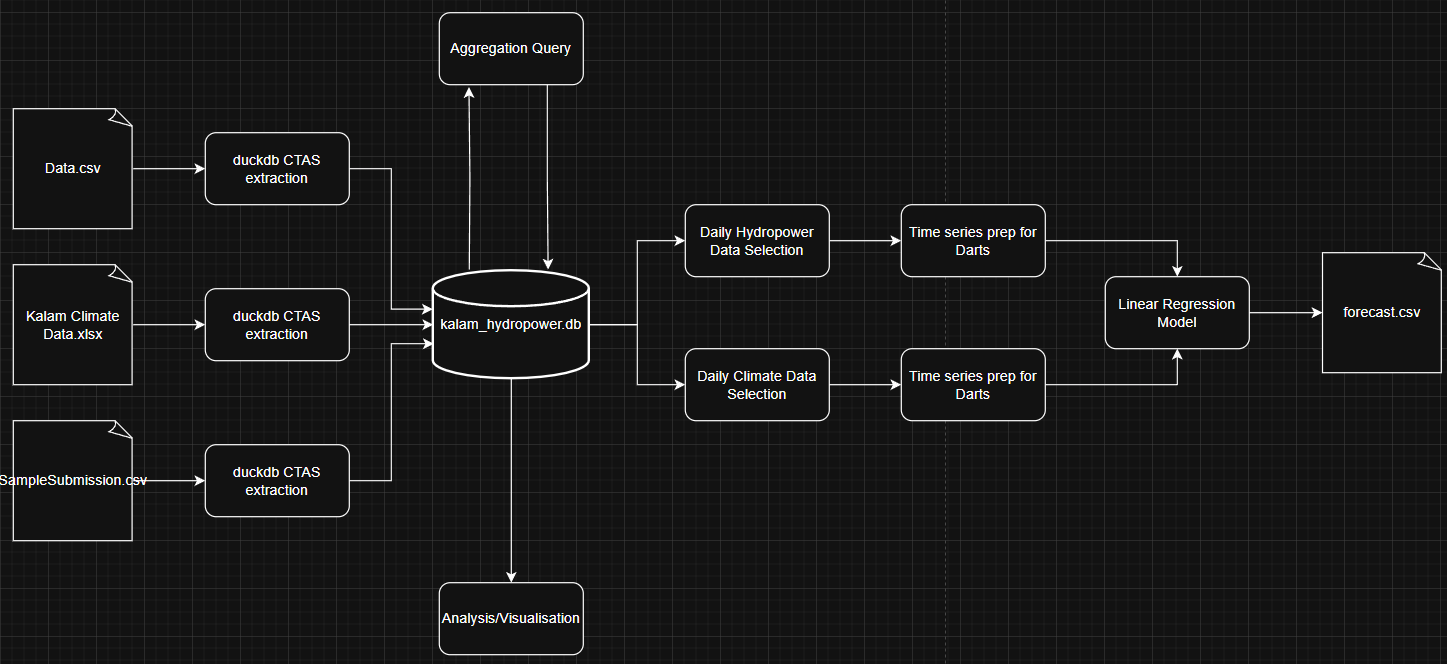

## ETL Process

### Extraction
- **Hydropower Data (`Data.csv`)**: Approximately 3GB in size, containing ~39 million records. Loaded into a DuckDB database to manage memory usage and enable fast SQL-style querying on disk.
- **Climate Data (`Kalam Climate Data.xlsx`)**: Extracted into DuckDB for consistent handling.
- **Sample Submission**: Used to align and validate the structure of the final forecast output.

### Transformation
- Aggregated both hydropower and climate data to **daily granularity** to align with the forecasting target.
- Created additional features for exploratory data analysis, including lag features and time-based attributes.
- Cleaned and normalized missing or corrupted values where necessary.

### Loading
- The transformed datasets remain within DuckDB for efficient retrieval.
- This also allows easy integration of results (e.g., forecasts) back into the same ecosystem for inspection or downstream usage.

---

## Data Modeling

- **Model Used**: `LinearRegressionModel` from the Darts library.
- **Assumptions**:
  - Energy generation patterns are influenced by historical trends and daily climate variables.
  - A linear relationship (with lags and covariates) is sufficient to capture underlying patterns.
- **Feature Engineering**:
  - Included lagged values of target variables and static covariates from climate data.
  - Normalized data using `StandardScaler` to ensure compatibility with the regression model.
- **Training Process**:
  - Trained on each of the series individually.
  - Evaluation via Root Mean Squared Error (RMSE).
  - Hyperparameter tuning was explored using `Optuna` (not included in the final run for simplicity).
- **Validation**:
  - Cross-validation using historical time slices for each series.
  - Forecast quality was compared visually and numerically using RMSE.

---

## Inference

- **Deployment**: Inference is performed in-batch inside the notebook using Darts’ built-in functionality.
- **New Data Input**: New daily values can be ingested by updating the DuckDB tables and re-running the prediction loop.
- **Forecast Output**: The model outputs a 31-day forecast per time series, which is compiled into a submission-ready format.
- **Model Updates**:
  - Retraining strategy involves re-running the entire pipeline with newly appended data.
  - Versioning of forecasts and inputs can be managed using database snapshots or file versioning.

### Model Equation

$$
\hat{y}_t = \beta_0 + \sum_{i=1}^{k} \beta_i y_{t-i} + \sum_{j=1}^{m} \gamma_j x_{t-j}
$$

Where:
- $ \hat{y}_t $: Predicted power usage at time $ t $
- $ y_{t-i} $: Lagged values of the target series (power usage)
- $ x_{t-j} $: Lagged or static exogenous covariates (e.g. temperature, wind speed, precipitation)
- $ \beta_0 $: Intercept term
- $ \beta_i $, $ \gamma_j $: Coefficients learned during training
- $ k $: Number of lags of the target series used (lookback period or **input/chunk length**)
- $ m $: Number of covariate features (lagged or static)

### Chunk Length

The parameter `input_chunk_length = k` defines how many previous time steps are considered when making a forecast. For example, with `input_chunk_length = 30`, the model uses the last 30 days of power usage and climate data to forecast future values.

This chunk serves as the **sliding window** over which the model "looks back" to make its predictions.

---

## Run Time

- **Notebook Execution Time**: ~54 seconds end-to-end on a machine with 32GB RAM and AMD Ryzen 7 CPU.
- **Heavy Processing**: Primarily during the aggregation and feature engineering phase, mitigated by DuckDB.

---

## Performance Metrics

- **Model Metric**: RMSE was used during validation for each time series.
- **Public Leaderboard Score**: *(insert your score here)*
- **Private Leaderboard Score**: *(insert your score here)*
- **Additional Observations**:
  - Simpler models (e.g., linear regression with lagged features) offered competitive performance due to the high signal-to-noise ratio in temporal patterns.
  - Complex models like deep learning were explored during experimentation but excluded from the final run due to compute constraints and marginal performance gains.

In [1]:
import time
tic = time.perf_counter()

import pandas as pd
import duckdb as ddb
import optuna
import numpy as np

from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.metrics import rmse
from darts.timeseries import concatenate

from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).


## Data Extraction and Aggregation

Due to the volume of data found in `Data.csv` I found it easier to operate on the data using DuckDB. At a high level I wanted a location from which I could easily extract data as and when I needed, as well as store results without flooding my RAM.

The steps taken are:
- Creating a DuckDB instance
- Importing data from the `Data.csv`, `Kalam Climate Data.xlsx` and `SampleSubmission.csv` files
- Aggregate the raw data (hydropower data and climate data) into a daily granularity tables
- Use the database as and when needed to store data

**NOTE** This step is perhaps unecessary for the final solution, I found using DuckDB useful while experimenting, however, to simply create the final result having a server/machine with > ~20GB of RAM could perform this processing without the use of a DB.

In [2]:
# Create the database and two schemas
con = ddb.connect("./kalam_hydropower.db")

try:
    con.sql("create schema 'raw';")
    con.sql("create schema 'prepared';")
except ddb.CatalogException as e:
    print(f"Schemas already exist.")

# This is a package needed to read excel natively in DDB
con.sql("INSTALL excel; LOAD excel")

Schemas already exist.


In [3]:
# Check the datatypes etc before loading - note that v_blue and v_yellow are detected as varchars and must be explicitly cast to doubles
con.sql("select * from read_csv('./data/Data.csv') limit 10;")

┌─────────────────────┬────────┬─────────┬──────────────┬────────────────────┬────────────────────────────────┬─────────┬──────────┬───────────────────┬───────────────────┐
│      date_time      │ v_red  │ current │ power_factor │        kwh         │             Source             │ v_blue  │ v_yellow │ consumer_device_9 │ consumer_device_x │
│      timestamp      │ double │ double  │    double    │       double       │            varchar             │ varchar │ varchar  │       int64       │       int64       │
├─────────────────────┼────────┼─────────┼──────────────┼────────────────────┼────────────────────────────────┼─────────┼──────────┼───────────────────┼───────────────────┤
│ 2024-07-22 18:20:00 │ 137.65 │    0.08 │         0.72 │         0.00066072 │ consumer_device_10_data_user_1 │ NULL    │ NULL     │                 0 │                10 │
│ 2024-07-22 18:25:00 │ 122.82 │    0.08 │         0.73 │ 0.0005977239999999 │ consumer_device_10_data_user_1 │ NULL    │ NULL     │   

In [4]:
# Create a table ignoring the columns consumer device 9 etc - these are assumed to be errors
try:
    con.sql("""
        create table raw.hydropower_production as
            select date_time, Source as source, v_red, cast(v_blue as double) as v_blue, cast(v_yellow as double) as v_yellow, current, kwh
            from read_csv('./data/Data.csv');
    """)
except ddb.CatalogException as e:
    print(f"Table already exists: {e}")

Table already exists: Catalog Error: Table with name "hydropower_production" already exists!


In [5]:
con.sql("select * from './data/Climate Data/Kalam Climate Data.xlsx' limit 10")

┌─────────────────────┬──────────────────┬───────────────────────────┬────────────────────────┬────────────────────────┬──────────────────────────┬───────────────┬────────────────┐
│      Date Time      │ Temperature (°C) │ Dewpoint Temperature (°C) │ U Wind Component (m/s) │ V Wind Component (m/s) │ Total Precipitation (mm) │ Snowfall (mm) │ Snow Cover (%) │
│      timestamp      │      double      │          double           │         double         │         double         │          double          │    double     │     double     │
├─────────────────────┼──────────────────┼───────────────────────────┼────────────────────────┼────────────────────────┼──────────────────────────┼───────────────┼────────────────┤
│ 2023-06-03 13:00:00 │      7.199731445 │              -2.448126221 │           -0.034194946 │             0.06098938 │                 0.000377 │           0.0 │    99.97265625 │
│ 2023-06-03 14:00:00 │      6.000619507 │              -2.597540283 │           -0.080688477 │

In [6]:
# Rename climate column names as the unusual characters make things difficult
try:
    con.sql("""
        create table raw.climate as
            select "Date Time" as date_time, "Temperature (°C)" as temperature, "Dewpoint Temperature (°C)" as dewpoint_temperature, "U Wind Component (m/s)" as u_wind_component, "V Wind Component (m/s)" as v_wind_component, "Total Precipitation (mm)" as total_precipitation, "Snowfall (mm)" as snowfall, "Snow Cover (%)" as snow_cover_perc
            from './data/Climate Data/Kalam Climate Data.xlsx'
    """)
except ddb.CatalogException as e:
    print(f"Table already exists: {e}")

Table already exists: Catalog Error: Table with name "climate" already exists!


In [7]:
try:
    con.sql("""
        create table raw.sample_submission as
            select * from read_csv('./data/SampleSubmission.csv')
    """)
except ddb.CatalogException as e:
    print(f"Table already exists: {e}")

Table already exists: Catalog Error: Table with name "sample_submission" already exists!


### Aggregation
The main goal here is to make the tables `raw.hydropower_production` and `raw.climate` exist at a daily granularity, this is easier to work with in pandas and the forecasting exercise/validation occurs on a daily level rather than at 5 minute or 1 hour intervals.

In [8]:
# Aggregate the power production data
try:
    con.sql("""
    create table prepared.daily_hydropower_production as
            with temp as (
                select
                    *,
                    cast(date_time as date) as date,
                    regexp_extract(source, 'consumer_device_(\d+)', 1) as consumer_device,
                    regexp_extract(source, '_data_user_(\d+)', 1) as data_user
                from raw.hydropower_production
            )
            select
                date,
                source,
                consumer_device,
                data_user,
                sum(kwh) as kwh
            from temp
            group by date, source, consumer_device, data_user
            order by source, date
    """)
except ddb.CatalogException as e:
    print(f"Table already exists: {e}")

Table already exists: Catalog Error: Table with name "daily_hydropower_production" already exists!


In [9]:
con.sql("select * from prepared.daily_hydropower_production limit 10")

┌────────────┬────────────────────────────────┬─────────────────┬───────────┬──────────────────────┐
│    date    │             source             │ consumer_device │ data_user │         kwh          │
│    date    │            varchar             │     varchar     │  varchar  │        double        │
├────────────┼────────────────────────────────┼─────────────────┼───────────┼──────────────────────┤
│ 2024-07-22 │ consumer_device_10_data_user_1 │ 10              │ 1         │   0.0243301524166643 │
│ 2024-07-23 │ consumer_device_10_data_user_1 │ 10              │ 1         │  0.10355964899999259 │
│ 2024-07-24 │ consumer_device_10_data_user_1 │ 10              │ 1         │  0.13754253833332433 │
│ 2024-07-25 │ consumer_device_10_data_user_1 │ 10              │ 1         │  0.12101083841665729 │
│ 2024-07-26 │ consumer_device_10_data_user_1 │ 10              │ 1         │                  0.0 │
│ 2024-07-27 │ consumer_device_10_data_user_1 │ 10              │ 1         │              

In [10]:
# Similarly aggregate the climate data
try:
    con.sql("""
        create table prepared.daily_climate as (
        select
            cast(date_time as date) as date,
            avg(temperature) as avg_temperature,
            avg(dewpoint_temperature) as avg_dewpoint_temperature,
            avg(u_wind_component) as avg_u_wind_component,
            avg(v_wind_component) as avg_v_wind_component,
            sum(total_precipitation) as total_precipitation,
            sum(snowfall) as total_snowfall,
            avg(snow_cover_perc) as avg_snow_cover_perc
        from raw.climate
        group by cast(date_time as date)
    )
    """)
except ddb.CatalogException as e:
    print(f"Table already exists: {e}")

Table already exists: Catalog Error: Table with name "daily_climate" already exists!


## Analysis and Feature Engineering
Now that the data has been aggregated, it is easier to work with in pandas and visualise using matplotlib and seaborn. The inention of this section is to:
- Produce features that are intuitive - i.e. hypothesize on what could support forecasting
- Visualise the feature signals to understand how the data varies with the target signal over time
- Check the feature covariation with the target data (daily kwh) to get a sense of which features to try

In [11]:
univariate_df = con.sql("""
    select
        *
    from prepared.daily_hydropower_production
""").to_df()

univariate_df.head()

,date,source,consumer_device,data_user,kwh
0,2024-07-22,consumer_device_10_data_user_1,10,1,0.024330
1,2024-07-23,consumer_device_10_data_user_1,10,1,0.103560
2,2024-07-24,consumer_device_10_data_user_1,10,1,0.137543
3,2024-07-25,consumer_device_10_data_user_1,10,1,0.121011
4,2024-07-26,consumer_device_10_data_user_1,10,1,0.000000


In [12]:
# These are devices with weak signals which we can exclude from the analysis - these were mentioned in the samplesubmission notebook
devices_to_drop = ["3", "5", "11", "14", "15", "17", "24", "25", "27", "33", "4", "9"]

In [13]:
to_forecast_df = univariate_df[~(univariate_df["consumer_device"].isin(devices_to_drop))].copy()

In [14]:
# Pivot the data such that all the different device, user combinations become independent columns at the same length
to_forecast_pivotted_df = to_forecast_df.pivot(columns="source", index="date", values="kwh").copy()

# Not all of the signals have the same length, in this case I simply fill missing/non-existant values with a 0
to_forecast_pivotted_df.fillna(0, inplace=True)

to_forecast_pivotted_df.head()

source,consumer_device_10_data_user_1,consumer_device_10_data_user_10,consumer_device_10_data_user_11,consumer_device_10_data_user_12,consumer_device_10_data_user_13,consumer_device_10_data_user_14,consumer_device_10_data_user_15,consumer_device_10_data_user_16,consumer_device_10_data_user_17,consumer_device_10_data_user_18,...,consumer_device_8_data_user_17,consumer_device_8_data_user_18,consumer_device_8_data_user_2,consumer_device_8_data_user_3,consumer_device_8_data_user_4,consumer_device_8_data_user_5,consumer_device_8_data_user_6,consumer_device_8_data_user_7,consumer_device_8_data_user_8,consumer_device_8_data_user_9
date,,,,,,,,,,,,,,,,,,,,,
2023-06-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Now I melt the dataframe back into a row-based structure, but I am guarenteed that all signals are the same length
to_forecast_extended_df = to_forecast_pivotted_df.melt(value_vars=list(to_forecast_pivotted_df.columns), var_name="source", value_name="kwh", ignore_index=False)

to_forecast_extended_df.reset_index(inplace=True, drop=False)

to_forecast_extended_df.head()

,date,source,kwh
0,2023-06-24,consumer_device_10_data_user_1,0.0
1,2023-06-25,consumer_device_10_data_user_1,0.0
2,2023-06-26,consumer_device_10_data_user_1,0.0
3,2023-06-27,consumer_device_10_data_user_1,0.0
4,2023-06-28,consumer_device_10_data_user_1,0.0


In [16]:
# I create a dataframe with the sum of kwh across all user/device combinations for easy visualisation (i.e. one series instead of over 400)
power_df = to_forecast_extended_df[["date", "kwh"]].groupby("date", as_index=False).sum()

power_df.head()

,date,kwh
0,2023-06-24,0.001223
1,2023-06-25,0.000000
2,2023-06-26,0.000000
3,2023-06-27,0.000000
4,2023-06-28,0.000000


In [17]:
# Now I pull the daily climate data into a dataframe for feature engineering
climate_df = con.sql("select * from prepared.daily_climate").to_df()

climate_df.head()

,date,avg_temperature,avg_dewpoint_temperature,avg_u_wind_component,avg_v_wind_component,total_precipitation,total_snowfall,avg_snow_cover_perc
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,99.972656
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,99.972656
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,99.972656
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,99.972656
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.008650,0.000000e+00,99.972656


In [18]:
# Features taken from an example notebook - these seem intuitive as power production likely depends on rainfall and temperature (melting of snow)
climate_df["temp_dew_diff"] = climate_df["avg_temperature"] - climate_df["avg_dewpoint_temperature"]
climate_df["wind_speed"] = (climate_df["avg_u_wind_component"]**2 + climate_df["avg_v_wind_component"]**2)**0.5
climate_df["precip_snow_ratio"] = climate_df["total_precipitation"] / (climate_df["total_snowfall"] + 1e-6)
climate_df["precip_minus_snow"] = climate_df["total_precipitation"] - climate_df["total_snowfall"]

# Some more 'out there' features to try - these were basically some brainstorm features I thought might work
climate_df["rolling_precip_7d"] = climate_df["total_precipitation"].rolling(7).sum()
climate_df["rolling_snow_30d"] = climate_df["total_snowfall"].rolling(30).sum()
climate_df["melt_potential"] = climate_df["avg_temperature"] * climate_df["avg_snow_cover_perc"]
climate_df["wind_variability_3d"] = climate_df["wind_speed"].rolling(3).std()

In [19]:
# Temporal features - features based on time/seasonality
climate_df["dayofyear"] = climate_df["date"].dt.dayofyear
climate_df["month"] = climate_df["date"].dt.month
climate_df["sin_doy"] = np.sin(2 * np.pi * climate_df["dayofyear"] / 365)
climate_df["cos_doy"] = np.cos(2 * np.pi * climate_df["dayofyear"] / 365)

In [20]:
all_data_df = pd.merge(climate_df, power_df, on="date", how="left")

all_data_df.head()

,date,avg_temperature,avg_dewpoint_temperature,avg_u_wind_component,avg_v_wind_component,total_precipitation,total_snowfall,avg_snow_cover_perc,temp_dew_diff,wind_speed,...,precip_minus_snow,rolling_precip_7d,rolling_snow_30d,melt_potential,wind_variability_3d,dayofyear,month,sin_doy,cos_doy,kwh
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,99.972656,5.208944,0.658203,...,0.004557,NaN,NaN,185.977159,NaN,154,6,0.471160,-0.882048,NaN
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,99.972656,5.897942,0.536706,...,0.024096,NaN,NaN,399.164785,NaN,155,6,0.455907,-0.890028,NaN
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,99.972656,8.576181,0.518888,...,0.011578,NaN,NaN,479.321249,0.075815,156,6,0.440519,-0.897743,NaN
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,99.972656,10.975005,0.478963,...,0.008914,NaN,NaN,630.266635,0.029568,157,6,0.425000,-0.905193,NaN
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.008650,0.000000e+00,99.972656,10.969686,0.523335,...,0.008650,NaN,NaN,700.200726,0.024435,158,6,0.409356,-0.912375,NaN


In [21]:
# The features and the target data are all on different scales, and I want to observe the shape of the signals,
# so for this I produce a scaled set of data to visualise
scaler = StandardScaler()

numeric_columns = all_data_df.select_dtypes("number").columns

scaled_data_df = all_data_df.copy()
scaled_data_df[numeric_columns] = scaler.fit_transform(all_data_df[numeric_columns])

In [22]:
# Here I define the feature columns I want to plot against kwh
feature_columns = list(all_data_df.columns)

feature_columns.remove("date")
feature_columns.remove("kwh")

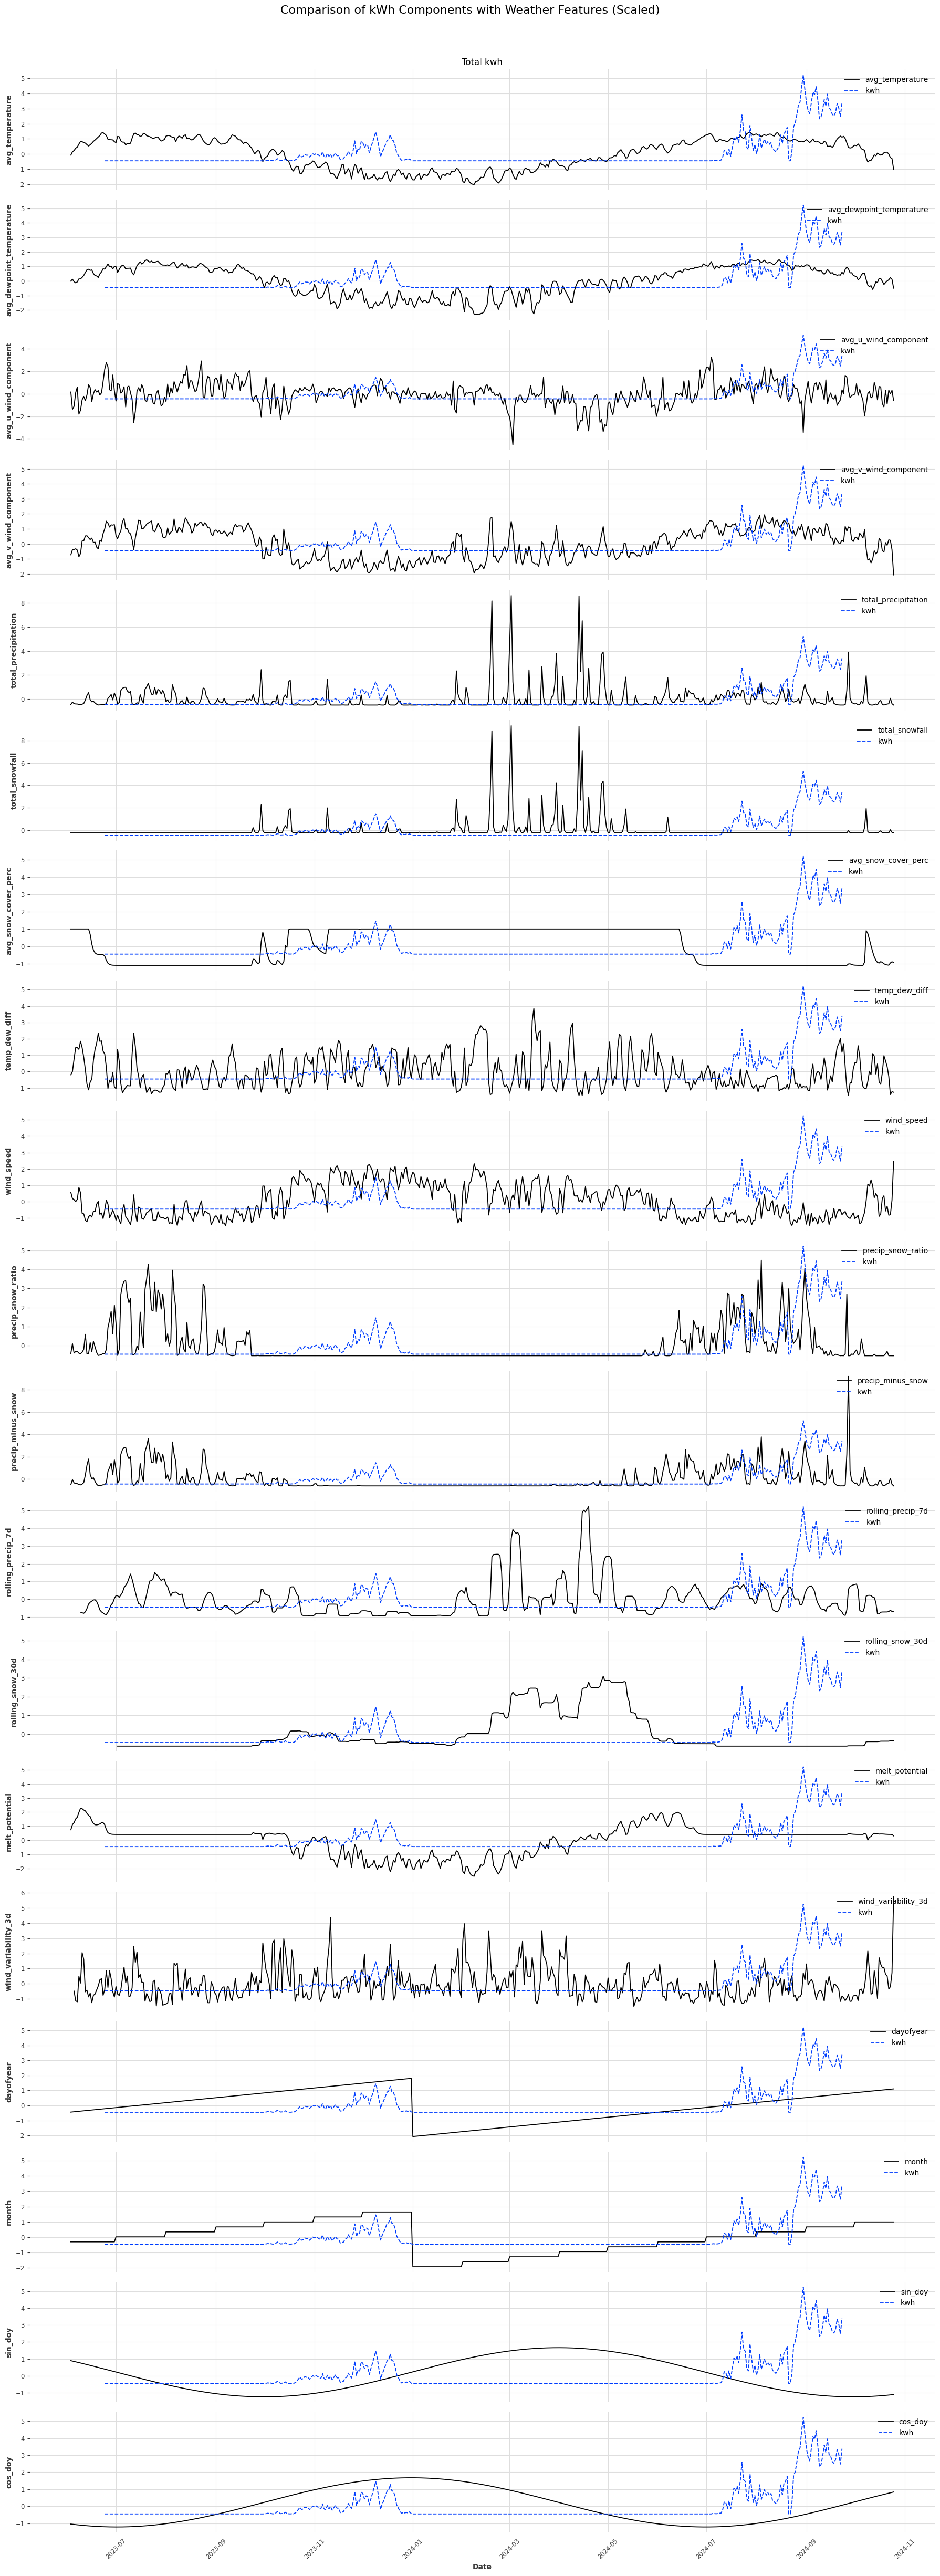

In [23]:
# Define the kWh components and feature components
kwh_components = ['kwh']
features = feature_columns

# Create subplots: one row per feature
fig, axes = plt.subplots(len(features), len(kwh_components), figsize=(18, 50), sharex=True)
fig.suptitle('Comparison of kWh Components with Weather Features (Scaled)', fontsize=16)

for i, weather in enumerate(features):
    ax = axes[i]
    ax.plot(scaled_data_df['date'], scaled_data_df[weather], label=weather)
    ax.plot(scaled_data_df['date'], scaled_data_df["kwh"], label="kwh", linestyle='--')
    ax.set_ylabel(weather)
    if i == len(features) - 1:
        ax.set_xlabel('Date')
    if i == 0:
        ax.set_title("Total kwh")
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

What is clear from these sub-plots is the following:
- There is a significant 'downtime' period from 2024-01 to 2024-07, no power is being produced between those times
- Precipitation minus snow (only rainfall) coincides with power production
- Snowfall does not seem to have an impact in 2024 - i.e. high snowfall does not imply high power production
- Temperature rises in 2024 seem to coincide with power production
- There is clearly a seasonality in power production, and temporal features reflect that, sin_doy, dayofyear and month seem to be good candidates to reflect this

Now, given that this is a time series problem it may not be that the date-aligned features at some lag may be better predictors. I want to understand correlation over various lags of the features.

In [24]:
# Ensure that the data is ordered appropriately for the correlation check
all_data_df.sort_values(by="date", inplace=True)
all_data_df.head()

,date,avg_temperature,avg_dewpoint_temperature,avg_u_wind_component,avg_v_wind_component,total_precipitation,total_snowfall,avg_snow_cover_perc,temp_dew_diff,wind_speed,...,precip_minus_snow,rolling_precip_7d,rolling_snow_30d,melt_potential,wind_variability_3d,dayofyear,month,sin_doy,cos_doy,kwh
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,99.972656,5.208944,0.658203,...,0.004557,NaN,NaN,185.977159,NaN,154,6,0.471160,-0.882048,NaN
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,99.972656,5.897942,0.536706,...,0.024096,NaN,NaN,399.164785,NaN,155,6,0.455907,-0.890028,NaN
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,99.972656,8.576181,0.518888,...,0.011578,NaN,NaN,479.321249,0.075815,156,6,0.440519,-0.897743,NaN
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,99.972656,10.975005,0.478963,...,0.008914,NaN,NaN,630.266635,0.029568,157,6,0.425000,-0.905193,NaN
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.008650,0.000000e+00,99.972656,10.969686,0.523335,...,0.008650,NaN,NaN,700.200726,0.024435,158,6,0.409356,-0.912375,NaN


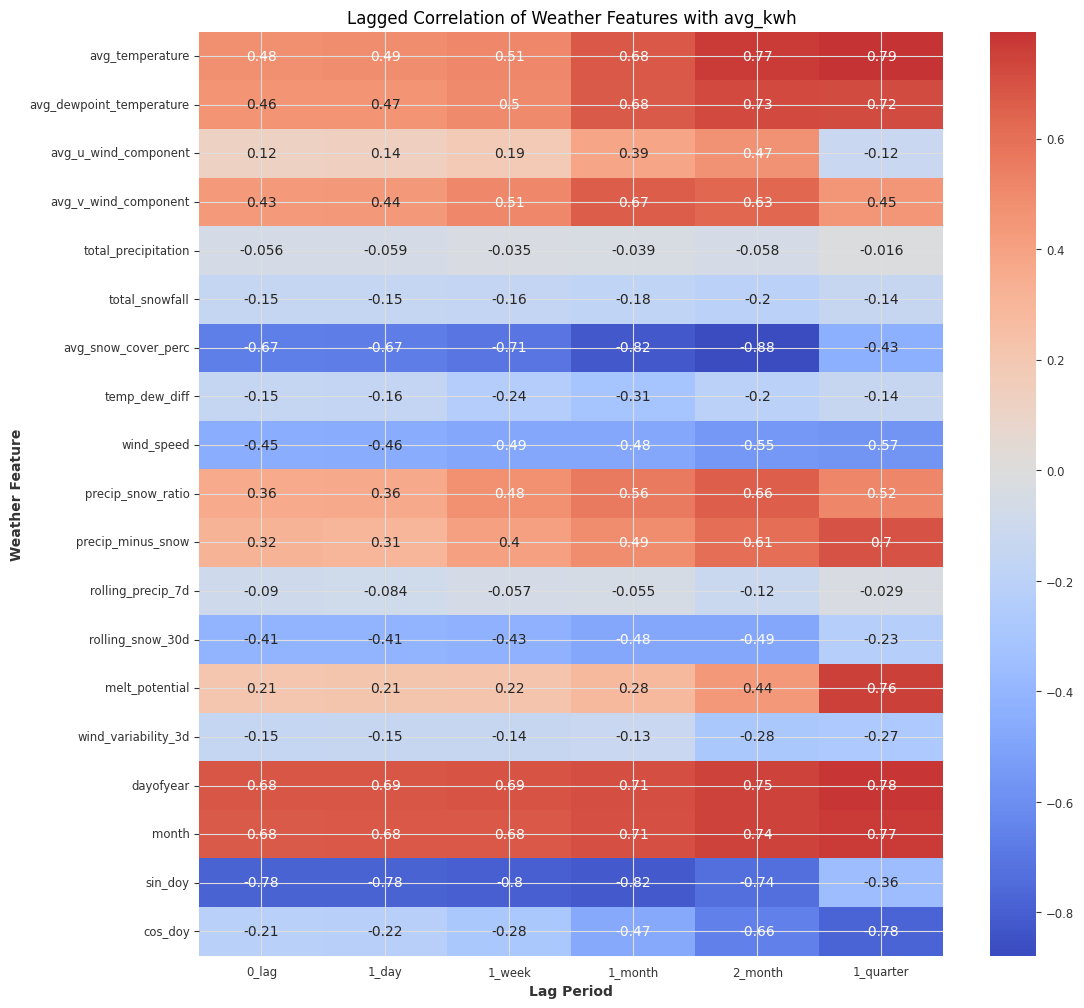

In [25]:
# Define lag periods (in days)
lags = {
    '0_lag': 0,
    '1_day': 1,
    '1_week': 7,
    '1_month': 30,
    '2_month': 60,
    '1_quarter': 90
}

# Store correlations for each lag
lagged_corrs = pd.DataFrame(index=features)

for label, lag_days in lags.items():
    df_lagged = all_data_df[all_data_df["date"] >= pd.Timestamp("2024-01-01")].copy()
    for feature in features:
        df_lagged[feature + '_lag'] = df_lagged[feature].shift(lag_days)
    df_lagged = df_lagged.dropna(subset=[f + '_lag' for f in features])
    
    corr_series = df_lagged[[f + '_lag' for f in features] + ['kwh']].corr()['kwh']
    # Drop 'kwh' itself and rename the index to remove '_lag'
    corr_series = corr_series.drop('kwh')
    corr_series.index = [i.replace('_lag', '') for i in corr_series.index]
    
    lagged_corrs[label] = corr_series

# Plot the results
plt.figure(figsize=(12, 12))
sns.heatmap(lagged_corrs, annot=True, cmap='coolwarm', center=0)
plt.title('Lagged Correlation of Weather Features with avg_kwh')
plt.ylabel('Weather Feature')
plt.xlabel('Lag Period')
plt.show()


The following features at a lag of 30 days (~1month) seem to be good candidates
- Temperature/dewpoint temperature
- Wind speed
- Precip minus snow (rainfall)
- Precip to snow ratio

Now some of the features have strong correlations (like those involving snow) but looking at the signal plots, these could be spurrious relationships and don't make intuitive sense to use.

## Modelling and Submission

Now that we have an idea of features and reasonable data structures, this next section aims to:
- Structure the data to be used with the Darts package - this depends on a `TimeSeries` data type rather than dataframes
- Splitting and scaling the data appropriately to avoid leakage in our test sets
- Creating an appropriate scoring and prediction function to easily format our results

In [26]:
# It is clear from our sub-plots that there is a long period of 'no signal' in the data, so I'll use data from 2024-07-01 onward
# for simplicity and to avoid too much zero biasing. Ofcourse, the fillna(0) adds some degree of biasing as well
filtered_to_forecast_df = con.sql(
    """select
        date, source, consumer_device, data_user, kwh 
    from prepared.daily_hydropower_production
""").to_df()

filtered_to_forecast_df = filtered_to_forecast_df[~(filtered_to_forecast_df["consumer_device"].isin(devices_to_drop))]

filtered_to_forecast_pivotted_df = filtered_to_forecast_df.pivot(columns="source", index="date", values="kwh").copy()
filtered_to_forecast_pivotted_df.fillna(0, inplace=True)

filtered_to_forecast_df = filtered_to_forecast_pivotted_df.melt(value_vars=list(filtered_to_forecast_pivotted_df.columns), var_name="source", value_name="kwh", ignore_index=False)

filtered_to_forecast_df.reset_index(inplace=True, drop=False)


filtered_to_forecast_df = filtered_to_forecast_df[filtered_to_forecast_df["date"] >= pd.Timestamp("2024-07-01")]

filtered_to_forecast_df.head()


,date,source,kwh
373,2024-07-01,consumer_device_10_data_user_1,0.0
374,2024-07-02,consumer_device_10_data_user_1,0.0
375,2024-07-03,consumer_device_10_data_user_1,0.0
376,2024-07-04,consumer_device_10_data_user_1,0.0
377,2024-07-05,consumer_device_10_data_user_1,0.0


In [27]:
filtered_to_forecast_df.shape

(35785, 3)

In [28]:
# Now I acutally want to use the device, user and source as static covariates in darts, this is a bit of a roundabout
# way of getting to the values but this gets the consumer device and data user numbers back
filtered_to_forecast_df[['consumer_device', 'data_user']] = filtered_to_forecast_df['source'].str.extract(r'consumer_device_(\d+)_data_user_(\d+)')
filtered_to_forecast_df["consumer_device"] = filtered_to_forecast_df["consumer_device"].astype(int)
filtered_to_forecast_df["data_user"] = filtered_to_forecast_df["data_user"].astype(int)

In [29]:
filtered_to_forecast_df.shape

(35785, 5)

In [30]:
vector_ts = TimeSeries.from_group_dataframe(
    filtered_to_forecast_df,
    time_col="date",
    group_cols="source",
    static_cols=["consumer_device", "data_user"],
    value_cols=["kwh"]
)

In [31]:
vector_ts[0].static_covariates_values()[0][0]

'consumer_device_10_data_user_1'

In [32]:
static_cov_scaler = StaticCovariatesTransformer(transformer_num=StandardScaler())

vector_encoded_ts = static_cov_scaler.fit_transform(vector_ts)

In [33]:
vector_encoded_ts[0].static_covariates

static_covariates,source,consumer_device,data_user
component,,,
kwh,0.0,-1.0319,-1.547864


In [34]:
# I setup a dictionary with a key per series, and a value containing the darts timeseries' incl. training, testing and scaled data
# as well as the individual scalers used to invert the transformation
ts_dict = {}

for index, series_ts in enumerate(vector_encoded_ts):
        
    try:

        series_name = vector_ts[index].static_covariates_values()[0][0]

        scaler = Scaler(StandardScaler())

        series_scaled_ts = scaler.fit_transform(series_ts)

        train_ts, test_ts = series_ts.split_after(len(series_ts) - 31)

        train_scaler = Scaler(StandardScaler())

        train_scaled_ts = train_scaler.fit_transform(train_ts)

    except Exception as e:
        print(f"Failed to process series {series_name} due to {e}")
        continue

    ts_dict[series_name] = {
        "ts": series_ts,
        "scaled_ts": series_scaled_ts,
        "scaler": scaler,
        "train_ts": train_ts,
        "train_scaled_ts": train_scaled_ts,
        "train_scaler": train_scaler,
        "test_ts": test_ts,
    }


In [35]:
# In darts you can pass a list of timeseries to a model's .fit function so that the model is trained on multiple series at once
train_ts_list = [ts_dict[series_name]["train_scaled_ts"] for series_name in ts_dict.keys()]

# These are the full series which we will use to train the final model
ts_list = [ts_dict[series_name]["scaled_ts"] for series_name in ts_dict.keys()]

In [36]:
# The features we want to use need to also be scaled so that they can be used with a model like LinearRegression
features_ts = TimeSeries.from_dataframe(climate_df, time_col="date")

features_scaler = Scaler(StandardScaler())

scaled_features_ts = features_scaler.fit_transform(features_ts)

In [37]:
# I need the sample submission file to produce an 'accurate score' i.e. how well am I doing on the series that my model will
# actually be validated on
ss_df = pd.read_csv("./data/SampleSubmission.csv")
ss_df[["date", "source"]] = ss_df["ID"].str.split("_", expand=True, n=1)

ss_df["date"] = pd.to_datetime(ss_df["date"])

ss_df.head()

,ID,kwh,date,source
0,2024-09-24_consumer_device_12_data_user_1,0,2024-09-24,consumer_device_12_data_user_1
1,2024-09-25_consumer_device_12_data_user_1,0,2024-09-25,consumer_device_12_data_user_1
2,2024-09-26_consumer_device_12_data_user_1,0,2024-09-26,consumer_device_12_data_user_1
3,2024-09-27_consumer_device_12_data_user_1,0,2024-09-27,consumer_device_12_data_user_1
4,2024-09-28_consumer_device_12_data_user_1,0,2024-09-28,consumer_device_12_data_user_1


In [38]:
def score_model(model, ts_dict, ss_df, future_covs=None, forecast_horizon=31, scaled=False):
    """A utility function to score a model based on the data in the submission set"""

    rmse_scores = []

    series_to_forecast = ts_dict.keys()##set(ts_dict.keys()).intersection(set(ss_df["source"].unique()))

    for index, series_name in enumerate(series_to_forecast):

        predictions = model.predict(forecast_horizon, series=ts_dict[series_name]["train_scaled_ts"], future_covariates=future_covs[index], show_warnings=False)

        if scaled:
            predictions = ts_dict[series_name]["train_scaler"].inverse_transform(predictions)
        
        rmse_scores.append(rmse(ts_dict[series_name]["test_ts"], predictions))
    
    return np.mean(rmse_scores)

In [39]:
def create_predictions(model, ts_dict, ss_df, future_covs, forecast_horizon=31, scaled=False):
    """A utility function which can easily create a submission based on the sample submission file"""

    predictions_df = pd.DataFrame()

    series_to_forecast = set(ts_dict.keys()).intersection(set(ss_df["source"].unique()))

    for index, series_name in enumerate(series_to_forecast):

        predictions = model.predict(forecast_horizon, series=ts_dict[series_name]["scaled_ts"], future_covariates=future_covs[index])

        if scaled:
            predictions = ts_dict[series_name]["scaler"].inverse_transform(predictions)

        pred_df = predictions.to_dataframe()
        pred_df["source"] = series_name

        predictions_df = pd.concat([predictions_df, pred_df])


        predictions_df.sort_values(by=["source", "date"], inplace=True)

        predictions_df["ID"] = predictions_df.index.astype(str) + "_" + predictions_df["source"]

    return predictions_df

In [40]:
model_kwargs = {
    "lags": [-1],
    "output_chunk_length": 9,
    "lags_future_covariates": [-30],
    "use_static_covariates": False,
    "random_state": 42
}

In [41]:
## Setting up my model
linear_model = LinearRegressionModel(
    **model_kwargs
)

future_covs = [scaled_features_ts[['precip_snow_ratio']] for _ in range(len(train_ts_list))]

linear_model.fit(train_ts_list, future_covariates=future_covs)

LinearRegressionModel(lags=[-1], lags_past_covariates=None, lags_future_covariates=[-30], output_chunk_length=9, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=False)

In [42]:
score_model(linear_model, ts_dict, ss_df, future_covs, scaled=True)

3.113364634140576

In [43]:
## Full model - now we can use all the data available to us to make the best model possible
full_model = LinearRegressionModel(
    **model_kwargs
)

future_covs = [scaled_features_ts[['precip_snow_ratio']] for _ in range(len(ts_list))]

full_model.fit(ts_list, future_covariates=future_covs)

LinearRegressionModel(lags=[-1], lags_past_covariates=None, lags_future_covariates=[-30], output_chunk_length=9, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=False)

In [44]:
forecast_df = create_predictions(full_model, ts_dict, ss_df, future_covs, scaled=True)

forecast_df.head()

component,kwh,source,ID
date,,,
2024-09-24,0.165820,consumer_device_12_data_user_1,2024-09-24_consumer_device_12_data_user_1
2024-09-25,0.156552,consumer_device_12_data_user_1,2024-09-25_consumer_device_12_data_user_1
2024-09-26,0.150046,consumer_device_12_data_user_1,2024-09-26_consumer_device_12_data_user_1
2024-09-27,0.147673,consumer_device_12_data_user_1,2024-09-27_consumer_device_12_data_user_1
2024-09-28,0.146711,consumer_device_12_data_user_1,2024-09-28_consumer_device_12_data_user_1


In [45]:
forecast_df[["ID","kwh"]].to_csv("./submissions/forecast.csv", index=False)

In [46]:
# con.close()

In [47]:
toc = time.perf_counter()

runtime = toc - tic

print(f"Total runtime is: {runtime}s or {runtime//60} mins and {(runtime%60)}s")

Total runtime is: 44.48877629998606s or 0.0 mins and 44.48877629998606s
